In [3]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [4]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [42]:
# Function to load DICOM image
def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    # image_array = dicom_data.pixel_array.astype(np.float32)[: 450, 200: 1300]
    image_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize image to range [0, 1]
    min_val = np.min(image_array)
    max_val = np.max(image_array)
    if max_val > min_val:  # Avoid division by zero
        image_array = (image_array - min_val) / (max_val - min_val)
    
    return image_array, dicom_data


def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)


def get_bounding_box(mask, padding=10):
    """
    Compute the bounding box around the nonzero mask region with optional padding.
    
    Args:
        mask (numpy array): Binary mask where nonzero pixels represent the object.
        padding (int): Extra pixels to add around the bounding box.
    
    Returns:
        (y_min, y_max, x_min, x_max): Cropped bounding box coordinates.
    """

    coords = np.argwhere(mask > 0)  

    if coords.size == 0:
        return None  # No object found

    # Get bounding box coordinates
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)


    y_min = max(y_min - padding, 0)
    x_min = max(x_min - padding, 0)
    y_max = min(y_max + padding, mask.shape[0])
    x_max = min(x_max + padding, mask.shape[1])

    return y_min, y_max, x_min, x_max

In [59]:
def dicom_index_generator(dicom_dir):
    num_files = len(os.listdir(dicom_dir))  # Count the number of files
    for i in range(num_files):
        yield i  # Yield index one by one
gen = dicom_index_generator(dicom_dir)


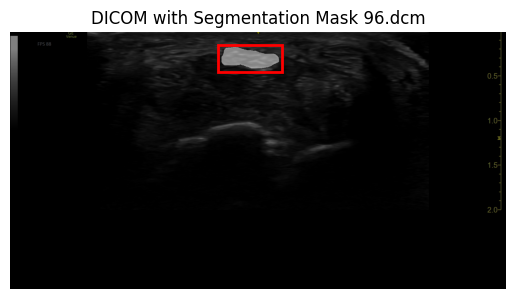

In [189]:

# dicom_filename = os.listdir(dicom_dir)[next(gen)]  
dicom_filename = '96.dcm'
mask_filename = os.path.splitext(dicom_filename)[0] + ".nii.gz"  

dicom_path = os.path.join(dicom_dir, dicom_filename)
mask_path = os.path.join(anno_dir, mask_filename)


dicom_image, dicom_data = load_dicom(dicom_path)
mask_image = load_mask(mask_path)


dicom_image = (dicom_image - np.min(dicom_image)) / (np.max(dicom_image) - np.min(dicom_image))

# Overlay mask on image
a = False
if get_bounding_box(mask_image[0]):
    a = True
    y_min, y_max, x_min, x_max = get_bounding_box(mask_image[0])
fig, ax = plt.subplots()
ax.imshow(dicom_image, cmap='gray')
ax.imshow(mask_image[0], cmap='gray', alpha=0.5)  # Overlay with transparency
if a:
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                      edgecolor='red', linewidth=2, fill=False))
ax.set_title(f"DICOM with Segmentation Mask {dicom_filename}")
ax.axis('off')
plt.show()

In [94]:
# 95 97 178

None


In [7]:
dicom_data.pixel_array.shape

(796, 1536, 3)